# Lesson 13.1:  Autoencoders



### Imports and load MNIST digit dataset

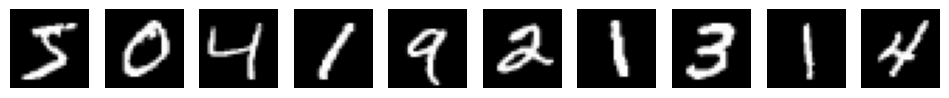

In [1]:
# (Optional) If you're on a fresh Colab: uncomment to ensure latest TF/Keras.
# %pip -q install -U tensorflow keras

import os, math, numpy as np, tensorflow as tf
import matplotlib.pyplot as plt

import keras
from keras import layers, ops, models, optimizers, callbacks
from sklearn.model_selection import train_test_split

# Data: MNIST 28x28 grayscale, scaled to [0,1]

(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

X_train = X_train.astype("float32") / 255.0
X_test  = X_test.astype("float32") / 255.0

# Add channel dim: (N, 28, 28, 1)
X_train = np.expand_dims(X_train, -1)
X_test  = np.expand_dims(X_test, -1)

# Merge all images (and labels if you want them for analysis)
X_all = np.concatenate([X_train, X_test], axis=0)
y_all = np.concatenate([y_train, y_test], axis=0)

# Random 90/10 split for training vs validation
X_tr, X_val, y_tr, y_val = train_test_split(
    X_all, y_all, test_size=0.10, random_state=42, stratify=y_all
)


def show_images(imgs, n=10, title=None):
    """Show first n images from a batch (28x28x1)."""
    imgs = imgs[:n].squeeze()
    cols = n
    plt.figure(figsize=(1.2*cols, 1.5))
    for i in range(n):
        plt.subplot(1, cols, i+1)
        plt.imshow(imgs[i], cmap="gray", vmin=0, vmax=1)
        plt.axis("off")
    if title:
        plt.suptitle(title, y=0.95)
    plt.show()

show_images(X_train)

# Part A: CNN-based Autoencoder

### Build

This cell builds a compact convolutional autoencoder for $28\times28$ grayscale images. The encoder compresses an input into a 3-D latent vector via conv + pooling, and the decoder upsamples that latent code with transposed convolutions to reconstruct a $28\times28$ image.

In [2]:

# ----- CNN Autoencoder for MNIST (simple & fast) -----

latent_dim = 16   # Latent space size set here

# ----- Encoder (Sequential) -----
encoder = models.Sequential(
    [
        layers.Input(shape=(28, 28, 1)),
        layers.Conv2D(32, 3, activation="relu", padding="same"),
        layers.MaxPooling2D(),                     # 14x14
        layers.Conv2D(64, 3, activation="relu", padding="same"),
        layers.MaxPooling2D(),                     # 7x7
        layers.Flatten(),
        layers.Dense(latent_dim, name="latent_space"),
    ],
    name="encoder",
)

# ----- Decoder (Sequential) -----
decoder = models.Sequential(
    [
        layers.Input(shape=(latent_dim,)),
        layers.Dense(7 * 7 * 64, activation="relu"),
        layers.Reshape((7, 7, 64)),
        layers.Conv2DTranspose(64, 3, strides=2, activation="relu", padding="same"),  # 14x14
        layers.Conv2DTranspose(32, 3, strides=2, activation="relu", padding="same"),  # 28x28
        layers.Conv2D(1, 3, activation="sigmoid", padding="same"),
    ],
    name="decoder",
)

# ----- Autoencoder = Encoder ∘ Decoder (Sequential) -----
autoencoder = models.Sequential([encoder, decoder], name="autoencoder")

encoder.summary()
decoder.summary()
autoencoder.summary()


2025-11-09 19:45:07.603739: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Max
2025-11-09 19:45:07.603768: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2025-11-09 19:45:07.603772: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
I0000 00:00:1762735507.603811 6974602 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1762735507.603897 6974602 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_space (Dense)            │ (None, 16)             │        50,192 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,008 (269.56 KB)

 Trainable params: 69,008 (269.56 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 3136)           │        53,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 108,993 (425.75 KB)

 Trainable params: 108,993 (425.75 KB)

 Non-trainable params: 0 (0.00 B)

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Sequential)            │ (None, 16)             │        69,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Sequential)            │ (None, 28, 28, 1)      │       108,993 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,001 (695.32 KB)

 Trainable params: 178,001 (695.32 KB)

 Non-trainable params: 0 (0.00 B)

### Train

In [3]:
from keras import callbacks, optimizers
import tensorflow as tf
import os

# --- Metrics (if not already defined) ---
def psnr(y_true, y_pred):
    return tf.reduce_mean(tf.image.psnr(y_true, y_pred, max_val=1.0))

def ssim(y_true, y_pred):
    return tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

# --- Compile: MSE loss + perceptual metrics; clip grads for stability ---
autoencoder.compile(
    optimizer=optimizers.Adam(1e-3, clipnorm=1.0),
    loss="mse",
    metrics=[tf.keras.metrics.MeanSquaredError(name="mse"), psnr, ssim],
)

# autoencoder.compile(
#     optimizer=optimizers.Adam(1e-3),
#     loss="binary_crossentropy",                        # BCE pairs well with sigmoid+[0,1] pixels
#     metrics=[tf.keras.metrics.MeanSquaredError(name="mse"), psnr, ssim],
# )

# --- Callbacks ---
early_stop = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    min_delta=1e-4,
    restore_best_weights=True,
    verbose=1,
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1,
)


# --- Train ---
history = autoencoder.fit(
    X_tr, X_tr,
    validation_data=(X_val, X_val),
    epochs=50,
    batch_size=256,
    callbacks=[early_stop, reduce_lr],
    verbose=1,
)



Epoch 1/50


2025-11-09 19:45:08.114244: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


247/247 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0641 - mse: 0.0641 - psnr: 12.6281 - ssim: 0.2721 - val_loss: 0.0271 - val_mse: 0.0271 - val_psnr: 16.2198 - val_ssim: 0.6608 - learning_rate: 0.0010
Epoch 2/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0185 - mse: 0.0185 - psnr: 18.1760 - ssim: 0.7716 - val_loss: 0.0150 - val_mse: 0.0150 - val_psnr: 19.1336 - val_ssim: 0.8193 - learning_rate: 0.0010
Epoch 3/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0137 - mse: 0.0137 - psnr: 19.5393 - ssim: 0.8364 - val_loss: 0.0130 - val_mse: 0.0130 - val_psnr: 19.8365 - val_ssim: 0.8463 - learning_rate: 0.0010
Epoch 4/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0125 - mse: 0.0125 - psnr: 19.9864 - ssim: 0.8534 - val_loss: 0.0128 - val_mse: 0.0128 - val_psnr: 19.8339 - val_ssim: 0.8505 - learning_rate: 0.0010
Epoch 5/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0118 - mse: 0.0118 - psnr: 20.2284 - ssim: 0.8617 - val_loss: 0.0117 - val_mse: 0.0117 - val_psn

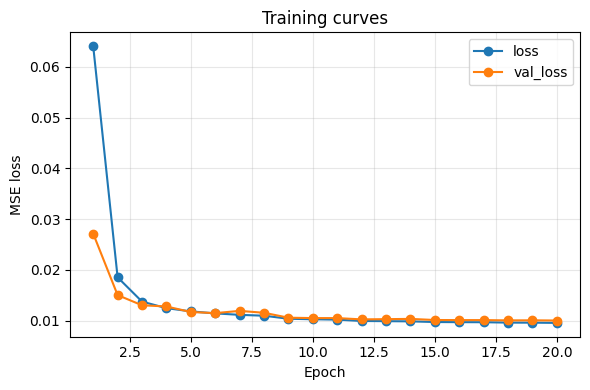

In [4]:
h = history.history
epochs = range(1, len(h["loss"]) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, h["loss"], marker="o", label="loss")
if "val_loss" in h:
    plt.plot(epochs, h["val_loss"], marker="o", label="val_loss")

plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.title("Training curves")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Demonstrate Reconstructions


-----------------------------------------------------------------------------------------------------------------------


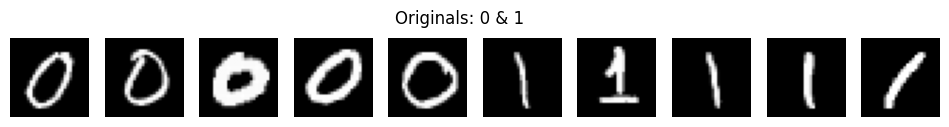

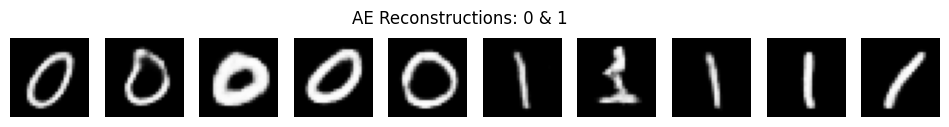

-----------------------------------------------------------------------------------------------------------------------


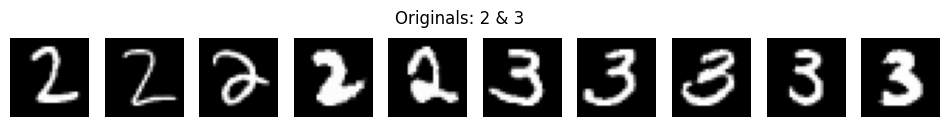

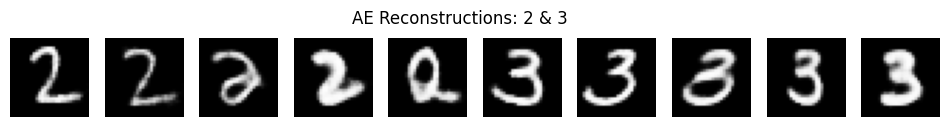

-----------------------------------------------------------------------------------------------------------------------


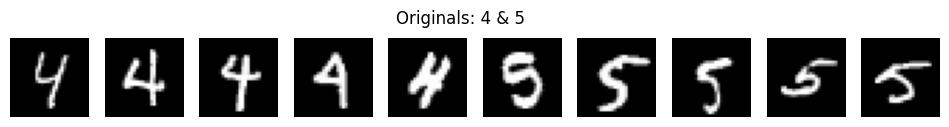

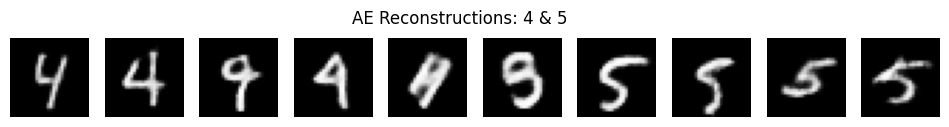

-----------------------------------------------------------------------------------------------------------------------


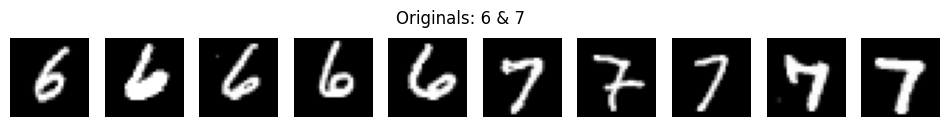

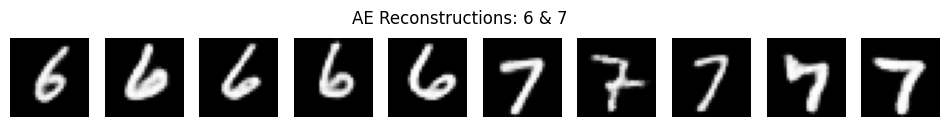

-----------------------------------------------------------------------------------------------------------------------


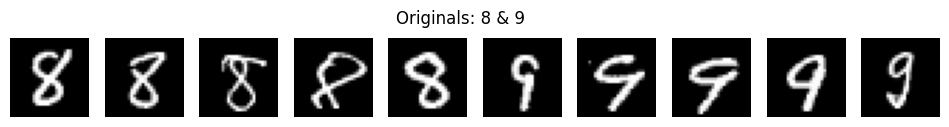

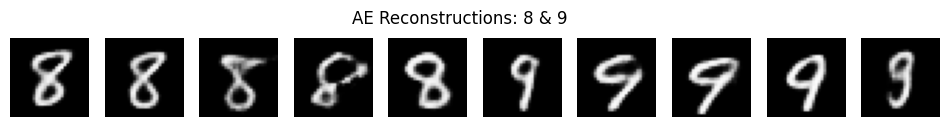

-----------------------------------------------------------------------------------------------------------------------


In [5]:
import numpy as np

# how many per class
k = 5

# RNG (set a seed for reproducibility; change/remove for fresh picks each run)
rng = np.random.default_rng()

pairs = [(0,1), (2,3), (4,5), (6,7), (8,9)]

print('-'*119)
for a, b in pairs:
    idx_a = np.where(y_test == a)[0]
    idx_b = np.where(y_test == b)[0]

    take_a = min(k, len(idx_a))
    take_b = min(k, len(idx_b))

    sel_a = rng.choice(idx_a, size=take_a, replace=False)
    sel_b = rng.choice(idx_b, size=take_b, replace=False)

    sel = np.concatenate([sel_a, sel_b])  # keep order: a's then b's
    batch = X_test[sel]
    recons = autoencoder.predict(batch, verbose=0)

    show_images(batch,  title=f"Originals: {a} & {b}")
    show_images(recons, title=f"AE Reconstructions: {a} & {b}")
    print('-'*119)

### Show worst examples of reconstructions from validation set

Top validation reconstruction errors (MSE):
 1. idx=3202  label=9  MSE=0.069700
 2. idx=6728  label=8  MSE=0.065002
 3. idx=4365  label=8  MSE=0.062907
 4. idx=2172  label=8  MSE=0.061249
 5. idx=1844  label=5  MSE=0.056759
 6. idx=2199  label=3  MSE=0.052783
 7. idx=6211  label=2  MSE=0.052427
 8. idx=596   label=2  MSE=0.052174
 9. idx=5838  label=3  MSE=0.051870
10. idx=736   label=3  MSE=0.051399
11. idx=3533  label=4  MSE=0.049266
12. idx=555   label=2  MSE=0.048238


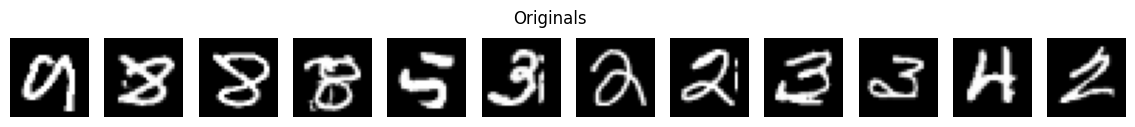

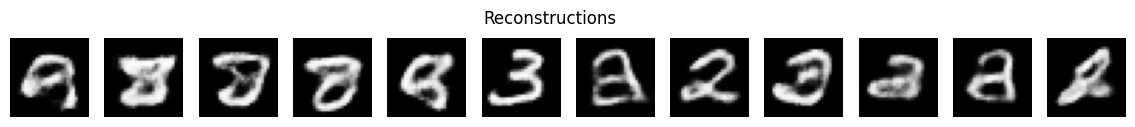

In [6]:
import numpy as np

# --- Reconstruct the validation split and compute per-image MSE ---
recons_val = autoencoder.predict(X_val, batch_size=512, verbose=0)
mse_val = np.mean((X_val - recons_val) ** 2, axis=(1, 2, 3))

# --- Select top-N worst by MSE ---
N = 12
worst_idx = np.argsort(mse_val)[-N:][::-1]   # highest errors first

# --- Print a small ranking table (labels optional) ---
print("Top validation reconstruction errors (MSE):")
has_labels = "y_val" in globals()
for rank, i in enumerate(worst_idx, start=1):
    lab = int(y_val[i]) if has_labels else "-"
    print(f"{rank:>2}. idx={i:<5} label={lab}  MSE={mse_val[i]:.6f}")

# --- Visualize originals and reconstructions ---
show_images(X_val[worst_idx],     n=len(worst_idx), title="Originals")
show_images(recons_val[worst_idx], n=len(worst_idx), title="Reconstructions")



### Creative Generalization

How well does our decoder work in returning a reasonable-looking image for a latent vector chosen randomly?

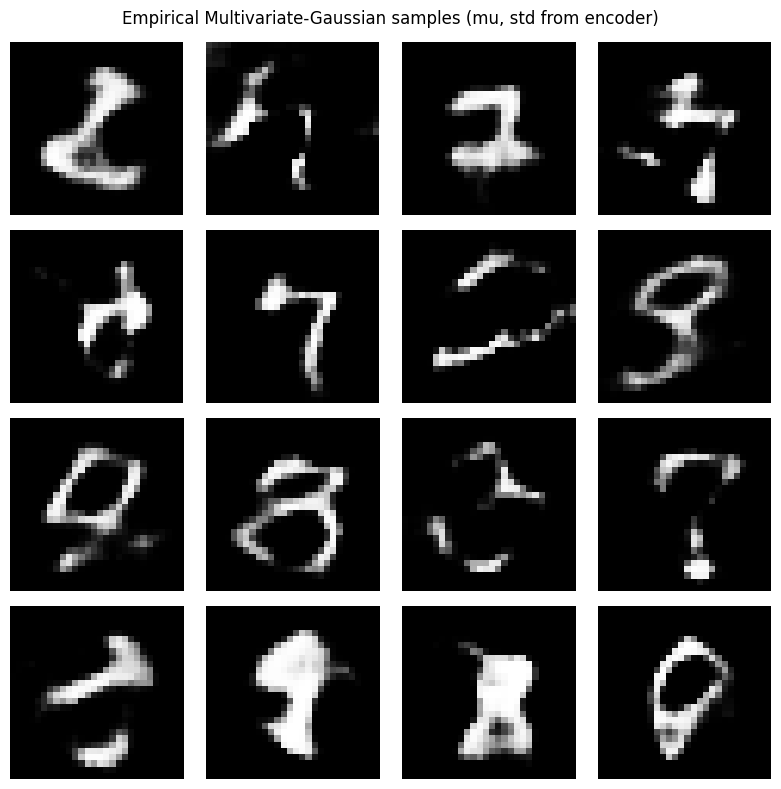

In [7]:
# ---- Choose some real images to probe latent space ----
X_src = None
for name in ["X_tr", "X_train", "x_train", "X_all", "x_test", "X_val"]:
    if name in globals():
        X_src = globals()[name]
        break
assert X_src is not None, "No input images found (need X_tr/X_train/x_train/...)."

# Encode a big-ish batch to learn the latent distribution
M = min(len(X_src), 20000)
Z = encoder.predict(X_src[:M], batch_size=512, verbose=0)   # shape: (M, latent_dim)

mu   = Z.mean(axis=0)                                       # (d,)
std  = Z.std(axis=0) + 1e-8
zmin = Z.min(axis=0)
zmax = Z.max(axis=0)
p01  = np.quantile(Z, 0.01, axis=0)
p99  = np.quantile(Z, 0.99, axis=0)

# # ---- Print concise stats ----
# print(f"Latent dim = {Z.shape[1]}, samples probed = {M}")
# print("dim   mean       std        min        max        p01        p99")
# for i in range(Z.shape[1]):
#     print(f"{i:>3}  {mu[i]: .4f}   {std[i]: .4f}   {zmin[i]: .4f}   {zmax[i]: .4f}   {p01[i]: .4f}   {p99[i]: .4f}")

# ---- Helpers ----
def decode_and_show(z, title="decoded", vmin=0, vmax=1):
    x = decoder.predict(z, verbose=0)
    N = len(x); cols = int(np.ceil(np.sqrt(N))); rows = int(np.ceil(N/cols))
    plt.figure(figsize=(2*cols, 2*rows))
    for i in range(N):
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(x[i].squeeze(), cmap="gray", vmin=vmin, vmax=vmax)
        ax.axis("off")
    plt.suptitle(title); plt.tight_layout(); plt.show()

N = 16  # number of samples to visualize

# (A) Empirical Gaussian near the data manifold
#     z ~ N(mu, Cov); using diagonal approx (per-dim std) is usually enough
z_emp_diag = mu + np.random.randn(N, Z.shape[1]).astype("float32") * std
decode_and_show(z_emp_diag, "Empirical Multivariate-Gaussian samples (mu, std from encoder)")




### Look at interpolations

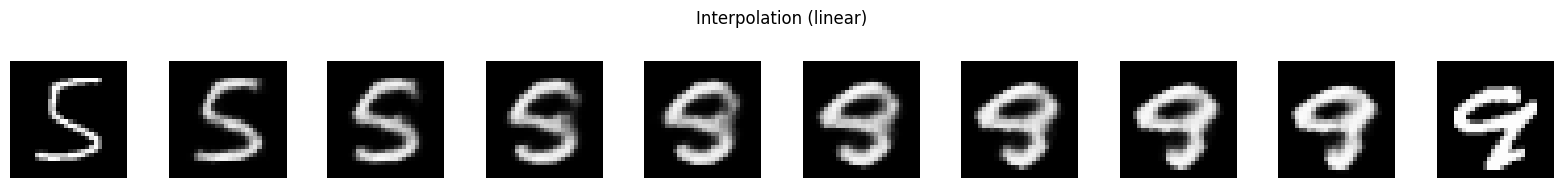

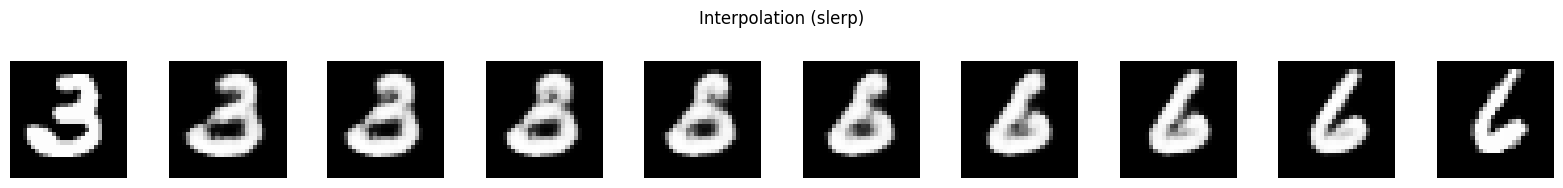

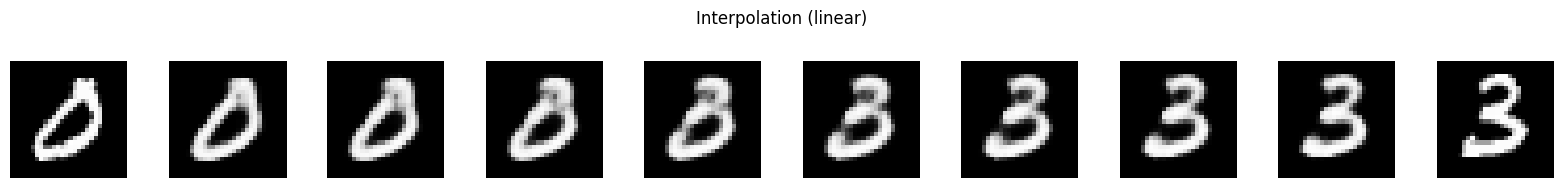

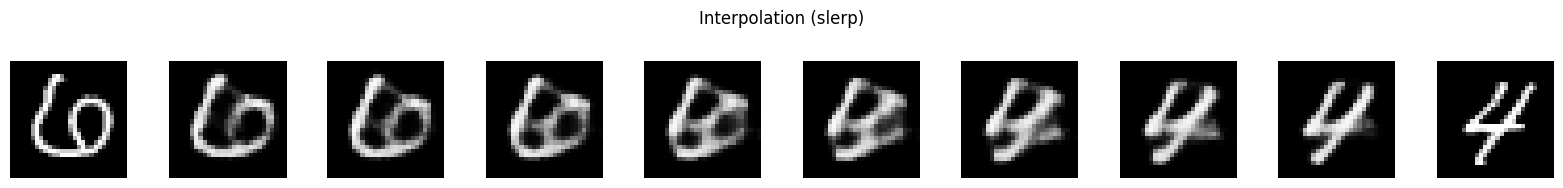

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- helpers ----------
def _rng(seed=0):
    return np.random.default_rng(seed)

def _show_row(images, title="", ncols=None):
    imgs = [np.asarray(img).squeeze() for img in images]
    n = len(imgs)
    ncols = n if ncols is None else ncols
    plt.figure(figsize=(1.6*ncols, 1.8))
    for i, im in enumerate(imgs, 1):
        ax = plt.subplot(1, ncols, i)
        ax.imshow(im, cmap="gray", vmin=0, vmax=1); ax.axis("off")
    if title:
        plt.suptitle(title, y=1.02)
    plt.tight_layout(); plt.show()

def _to_numpy(x):
    try:
        import tensorflow as tf
        if isinstance(x, tf.Tensor):
            return x.numpy()
    except Exception:
        pass
    return np.asarray(x)

def _encode_to_vector(encoder, x, mode="mean"):
    """
    Encodes x and returns latent vectors (batch, d).
    - For VAEs: mode='mean' uses z_mean if available; mode='sample' uses z if available.
    - For vanilla AEs: returns the single output.
    """
    out = encoder.predict(x, verbose=0)
    if isinstance(out, (list, tuple)):
        # Try to find z_mean / z_log_var / z by name/shape order
        cand_2d = [c for c in out if len(np.shape(c)) == 2]
        zvec = cand_2d[0]  # default to first 2D output
        if mode == "sample" and len(cand_2d) >= 2:
            zvec = cand_2d[-1]  # often z (reparameterized) is last
    else:
        zvec = out
    return _to_numpy(zvec)

def _slerp(a, b, t):
    """
    Spherical linear interpolation between a and b (batchless).
    a,b: (d,), t: scalar in [0,1]
    """
    a = a.astype(np.float32); b = b.astype(np.float32)
    a_norm = a / (np.linalg.norm(a) + 1e-8)
    b_norm = b / (np.linalg.norm(b) + 1e-8)
    dot = np.clip(np.dot(a_norm, b_norm), -1.0, 1.0)
    omega = np.arccos(dot)
    if omega < 1e-6:
        return (1.0 - t) * a + t * b
    s0 = np.sin((1.0 - t) * omega) / np.sin(omega)
    s1 = np.sin(t * omega) / np.sin(omega)
    return s0 * a + s1 * b

# ---------- main demo ----------
def demo_interpolation(X, encoder, decoder, n_steps=8, seed=0, mode="mean", kind="linear"):
    """
    Interpolate between two random images in latent space and decode.
      - mode: 'mean' or 'sample' (relevant for VAEs; ignored for vanilla AEs)
      - kind: 'linear' or 'slerp'
    """
    assert X.ndim == 4 and X.shape[-1] in (1, 3), "X should be (N, H, W, C) in [0,1]"
    rng = _rng(seed)

    # choose two distinct examples
    i, j = rng.choice(len(X), size=2, replace=False)
    x0, x1 = X[i:i+1], X[j:j+1]

    # encode to latent vectors
    z0 = _encode_to_vector(encoder, x0, mode=mode)[0]
    z1 = _encode_to_vector(encoder, x1, mode=mode)[0]

    # exclude endpoints (they'll be shown separately)
    alphas = np.linspace(0.0, 1.0, n_steps + 2, dtype=np.float32)[1:-1]  # (n_steps,)

    if kind == "slerp":
        z_interp = np.stack([_slerp(z0, z1, float(t)) for t in alphas], axis=0).astype("float32")
    else:
        z_interp = ((1 - alphas[:, None]) * z0[None, :] +
                    (alphas[:, None]) * z1[None, :]).astype("float32")

    # decode
    imgs = decoder.predict(z_interp, verbose=0)

    # visualize: [source] + steps + [target]
    _show_row([x0[0]] + [imgs[k] for k in range(n_steps)] + [x1[0]],
              title=f"Interpolation ({kind})", ncols=n_steps + 2)

# ---------- usage ----------
# For a vanilla AE, 'mode' is ignored; for VAEs prefer mode='mean'.
demo_interpolation(X_test, encoder, decoder, n_steps=8, seed=2,  kind="linear")
demo_interpolation(X_test, encoder, decoder, n_steps=8, seed=5,  kind="slerp")
demo_interpolation(X_test, encoder, decoder, n_steps=8, seed=4,  kind="linear")
demo_interpolation(X_test, encoder, decoder, n_steps=8, seed=8,  kind="slerp")


# Part B: Applications of Autoencoders

## Denoising and repainting

This demo trains a denoising autoencoder on MNIST: the encoder maps a noisy $28\times28$ image to a $64$-D latent vector, and the decoder reconstructs a clean image. We synthetically corrupt inputs each batch (Gaussian noise, salt-and-pepper, and random cutouts) but keep the clean images as targets; the model learns $$f(\text{noisy})\!\rightarrow\!\text{clean}.$$ 

It’s compiled with a sigmoid output and binary cross-entropy loss, while PSNR and SSIM track perceptual quality. Callbacks add EarlyStopping/LR scheduling, CSV logging, and a visualizer that saves side-by-side Noisy / Denoised / Clean panels each epoch. After training, the script plots loss/PSNR/SSIM curves and prints final test metrics.


### Build a noisy dataset

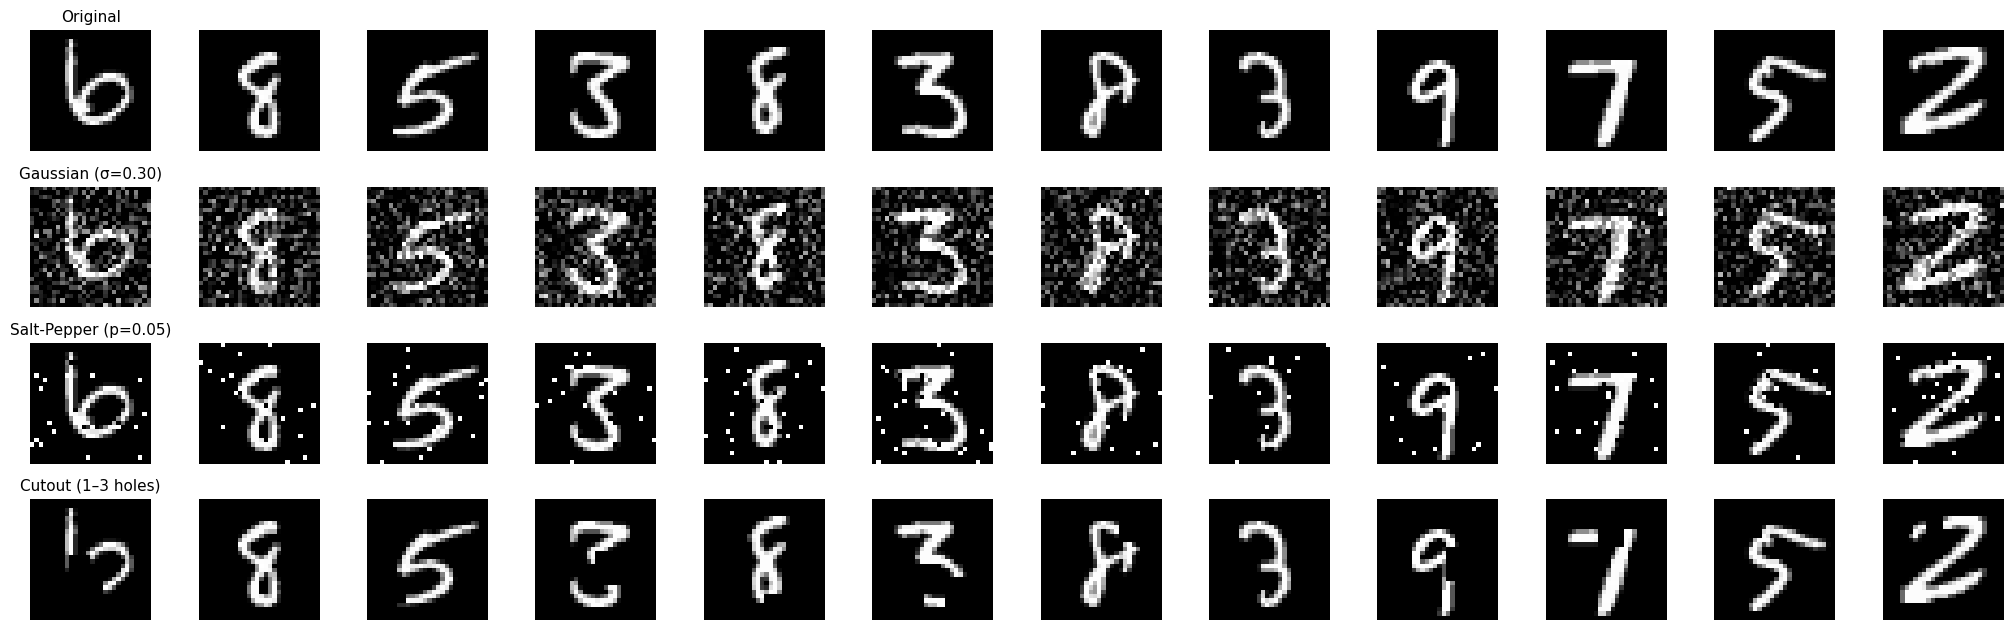

In [19]:
import numpy as np, matplotlib.pyplot as plt

# --- Noise functions (match your training code) ---
def add_gaussian(x, sigma=0.30):
    return np.clip(x + np.random.normal(0.0, sigma, x.shape), 0.0, 1.0)

def add_salt_pepper(x, p=0.05):
    x = x.copy()
    m = np.random.rand(*x.shape)
    x[m < (p/2)] = 0.0
    x[(m >= p/2) & (m < p)] = 1.0
    return x

def add_cutout_varied(x, n_holes_range=(1,3), size_range=(4,8)):
    x = x.copy()
    H, W = x.shape[1], x.shape[2]
    for i in range(len(x)):
        n_holes = np.random.randint(n_holes_range[0], n_holes_range[1] + 1)
        for _ in range(n_holes):
            h = np.random.randint(size_range[0], size_range[1] + 1)
            w = np.random.randint(size_range[0], size_range[1] + 1)
            y = np.random.randint(0, H - h + 1)
            z = np.random.randint(0, W - w + 1)
            x[i, y:y+h, z:z+w, :] = 0.0
    return x

# --- Pick a fixed set to visualize ---
np.random.seed(7)
idx = np.random.choice(len(X_test), size=12, replace=False)
x0 = X_test[idx]

x_gauss = add_gaussian(x0, sigma=0.30)
x_sp    = add_salt_pepper(x0, p=0.05)
x_cut   = add_cutout_varied(x0, n_holes_range=(1,3), size_range=(4,8))

# --- Plot 4 rows: Original / Gaussian / Salt-Pepper / Cutout ---
rows = ["Original", "Gaussian (σ=0.30)", "Salt-Pepper (p=0.05)", "Cutout (1–3 holes)"]
batches = [x0, x_gauss, x_sp, x_cut]

cols = len(x0)
plt.figure(figsize=(1.7*cols, 6.4))
for r, (name, batch) in enumerate(zip(rows, batches)):
    for c in range(cols):
        ax = plt.subplot(len(rows), cols, r*cols + c + 1)
        ax.imshow(batch[c].squeeze(), cmap="gray", vmin=0, vmax=1)
        ax.axis("off")
        if c == 0:
            ax.set_title(name, fontsize=11)
plt.tight_layout()
plt.show()


### Train our same CNN autoencoder design on this noisy dataset

Epoch 1/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.2372 - psnr: 13.0967 - ssim: 0.3082 - val_loss: 0.1384 - val_psnr: 16.5775 - val_ssim: 0.6781 - learning_rate: 0.0010
Epoch 2/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.1211 - psnr: 17.8662 - ssim: 0.7544 - val_loss: 0.1095 - val_psnr: 18.8216 - val_ssim: 0.8083 - learning_rate: 0.0010
Epoch 3/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.1058 - psnr: 19.2225 - ssim: 0.8224 - val_loss: 0.1015 - val_psnr: 19.6122 - val_ssim: 0.8355 - learning_rate: 0.0010
Epoch 4/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0993 - psnr: 19.9325 - ssim: 0.8496 - val_loss: 0.0966 - val_psnr: 20.2594 - val_ssim: 0.8629 - learning_rate: 0.0010
Epoch 5/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0954 - psnr: 20.4201 - ssim: 0.8656 - val_loss: 0.0942 - val_psnr: 20.5680 - val_ssim: 0.8716 - learning_rate: 0.0010
Epoch 6/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0929 - psnr: 20.7412 - ssim: 0.8

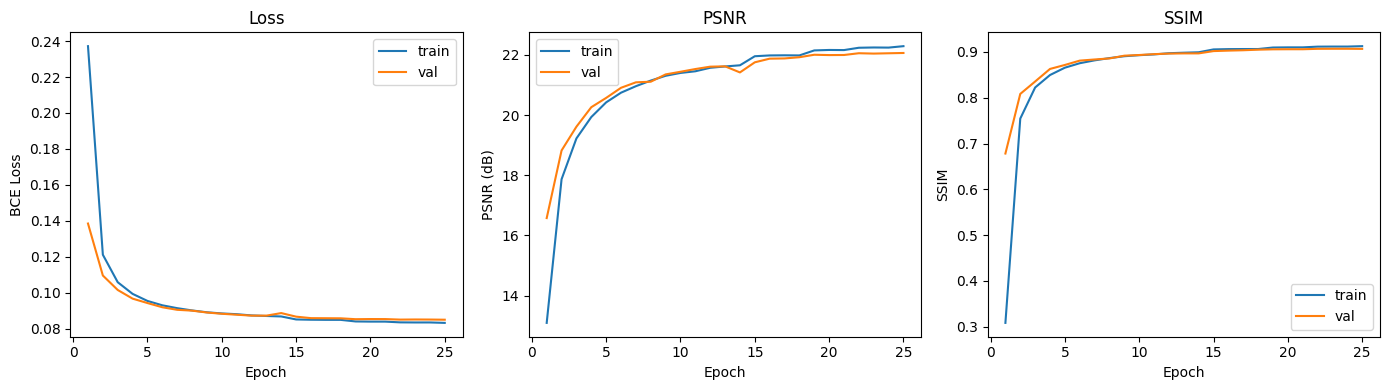

Test  - Loss(BCE): 0.0849 | PSNR: 22.06 dB | SSIM: 0.9067
Best epoch by val_loss: 25


In [10]:
import numpy as np
from tensorflow import keras
from keras import layers, models

# ----- Your model (unchanged except latent_dim) -----
latent_dim = 64   # <- was 3; 16–64 are reasonable for MNIST

encoder = models.Sequential(
    [
        layers.Input(shape=(28, 28, 1)),
        layers.Conv2D(32, 3, activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=2),                 # 14x14
        layers.Conv2D(64, 3, activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=2),                 # 7x7
        layers.Flatten(),
        layers.Dense(latent_dim, name="latent_space"),
    ],
    name="encoder",
)

decoder = models.Sequential(
    [
        layers.Input(shape=(latent_dim,)),
        layers.Dense(7 * 7 * 64, activation="relu"),
        layers.Reshape((7, 7, 64)),
        layers.Conv2DTranspose(64, 3, strides=2, activation="relu", padding="same"),  # 14x14
        layers.Conv2DTranspose(32, 3, strides=2, activation="relu", padding="same"),  # 28x28
        layers.Conv2D(1, 3, activation="sigmoid", padding="same"),
    ],
    name="decoder",
)

autoencoder = models.Sequential([encoder, decoder], name="autoencoder")

# ----- Data: clean targets + noisy inputs -----

def corrupt_batch(x):
    x_noisy = x.copy()
    r = np.random.rand(x.shape[0])
    if (r < 0.34).any():
        idx = np.where(r < 0.34)[0]
        x_noisy[idx] = add_gaussian(x_noisy[idx], sigma=0.30)
    if ((r >= 0.34) & (r < 0.67)).any():
        idx = np.where((r >= 0.34) & (r < 0.67))[0]
        x_noisy[idx] = add_salt_pepper(x_noisy[idx], p=0.03)
    if (r >= 0.67).any():
        idx = np.where(r >= 0.67)[0]
        x_noisy[idx] = add_cutout_varied(x_noisy[idx])
    return x_noisy

# Load MNIST
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
x_train = (x_train.astype("float32") / 255.0)[..., None]
x_test  = (x_test.astype("float32")  / 255.0)[..., None]

# Make noisy inputs; keep clean targets
x_train_noisy = corrupt_batch(x_train)
x_test_noisy  = corrupt_batch(x_test)

import tensorflow as tf

# --- Metrics ---
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os

def psnr(y_true, y_pred):
    # mean over batch so Keras logs a scalar
    return tf.reduce_mean(tf.image.psnr(y_true, y_pred, max_val=1.0))

def ssim(y_true, y_pred):
    return tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

# (Re)compile with metrics
autoencoder.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=[psnr, ssim],
)

# --- Fixed visualization set (so you can compare across epochs) ---
np.random.seed(42)
idx = np.random.choice(len(x_test), size=12, replace=False)
x_vis_clean = x_test[idx]
x_vis_noisy = x_test_noisy[idx]

# --- Callback: save reconstructions each epoch ---
class VisualizeReconstructions(keras.callbacks.Callback):
    def __init__(self, x_noisy, x_clean, out_dir="ae_figs"):
        super().__init__()
        self.x_noisy = x_noisy
        self.x_clean = x_clean
        self.out_dir = out_dir
        os.makedirs(out_dir, exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        preds = self.model.predict(self.x_noisy, verbose=0)
        n = len(self.x_noisy)
        cols = n
        plt.figure(figsize=(1.7*cols, 5.1))  # 3 rows: Noisy / Denoised / Clean
        for i in range(n):
            # Noisy
            ax = plt.subplot(3, cols, i+1)
            plt.imshow(self.x_noisy[i].squeeze(), cmap="gray", vmin=0, vmax=1)
            plt.axis("off")
            if i == 0: ax.set_title("Noisy")
            # Denoised
            ax = plt.subplot(3, cols, i+1+cols)
            plt.imshow(preds[i].squeeze(), cmap="gray", vmin=0, vmax=1)
            plt.axis("off")
            if i == 0: ax.set_title("Denoised")
            # Clean
            ax = plt.subplot(3, cols, i+1+2*cols)
            plt.imshow(self.x_clean[i].squeeze(), cmap="gray", vmin=0, vmax=1)
            plt.axis("off")
            if i == 0: ax.set_title("Clean")
        plt.tight_layout()
        fname = os.path.join(self.out_dir, f"recons_epoch_{epoch+1:02d}.png")
        plt.savefig(fname, dpi=120)
        plt.close()

viz_cb = VisualizeReconstructions(x_vis_noisy, x_vis_clean)

# --- CSV logging (+ keep your EarlyStopping) ---
csv_cb = keras.callbacks.CSVLogger("ae_mnist_metrics.csv", append=False)
early_cb = keras.callbacks.EarlyStopping(
    patience=5, restore_best_weights=True, monitor="val_loss"
)
rlr_cb = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=2, verbose=1
)

# (Optional) TensorBoard
# tb_cb = keras.callbacks.TensorBoard(log_dir="ae_tb", histogram_freq=0)

# --- Train ---
history = autoencoder.fit(
    x_train_noisy, x_train,
    validation_data=(x_test_noisy, x_test),
    epochs=25,
    batch_size=256,
    callbacks=[early_cb, rlr_cb, csv_cb, viz_cb],  # add tb_cb if you want
    verbose=1,
)

# --- Plot curves (loss, PSNR, SSIM) ---
hist = history.history
epochs = range(1, len(hist["loss"]) + 1)

plt.figure(figsize=(14, 4))
# Loss
plt.subplot(1, 3, 1)
plt.plot(epochs, hist["loss"], label="train")
plt.plot(epochs, hist["val_loss"], label="val")
plt.xlabel("Epoch"); plt.ylabel("BCE Loss"); plt.title("Loss"); plt.legend()

# PSNR
plt.subplot(1, 3, 2)
plt.plot(epochs, hist["psnr"], label="train")
plt.plot(epochs, hist["val_psnr"], label="val")
plt.xlabel("Epoch"); plt.ylabel("PSNR (dB)"); plt.title("PSNR"); plt.legend()

# SSIM
plt.subplot(1, 3, 3)
plt.plot(epochs, hist["ssim"], label="train")
plt.plot(epochs, hist["val_ssim"], label="val")
plt.xlabel("Epoch"); plt.ylabel("SSIM"); plt.title("SSIM"); plt.legend()

plt.tight_layout()
plt.show()

# --- Final evaluation on test set ---
test_loss, test_psnr, test_ssim = autoencoder.evaluate(
    x_test_noisy, x_test, batch_size=256, verbose=0
)
print(f"Test  - Loss(BCE): {test_loss:.4f} | PSNR: {test_psnr:.2f} dB | SSIM: {test_ssim:.4f}")

# Best epoch helper (by val_loss)
best_epoch = int(np.argmin(hist["val_loss"])) + 1
print(f"Best epoch by val_loss: {best_epoch}")



Here’s what each curve measures (brief and to the point):

* **BCE Loss (Binary Cross-Entropy):** Per-pixel cross-entropy between target $x\in[0,1]$ and prediction $\hat x\in(0,1)$ from the sigmoid head.
  $$\text{BCE}=-\frac1N\sum\big[x\log\hat x+(1-x)\log(1-\hat x)\big].$$
  Lower is better.

* **PSNR (Peak Signal-to-Noise Ratio):** Log measure of reconstruction fidelity derived from MSE; for images scaled to $[0,1]$:
  $$\text{PSNR}=20\log_{10}(1)-10\log_{10}(\text{MSE})=-10\log_{10}(\text{MSE}).$$
  Higher (in dB) is better.

* **SSIM (Structural Similarity Index):** Perceptual similarity comparing luminance, contrast, and structure:
  $$\text{SSIM}(x,\hat x)=\frac{(2\mu_x\mu_{\hat x}+C_1)(2\sigma_{x\hat x}+C_2)}{(\mu_x^2+\mu_{\hat x}^2+C_1)(\sigma_x^2+\sigma_{\hat x}^2+C_2)}.$$
  Ranges roughly $[0,1]$; higher is better and correlates with visual quality.

Rule of thumb for your plots: BCE ↓, PSNR ↑, SSIM ↑ as reconstructions improve; occasional validation dips suggest momentary overfitting or harder batches.

### Let's look at how it did

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# ---------- 1) Random gallery: Noisy → Denoised → Clean ----------
def show_triplets(model, x_noisy, x_clean, n=12, seed=42, savepath=None):
    """
    Shows n examples in 3 rows: Noisy / Denoised / Clean.
    """
    rng = np.random.default_rng(seed)
    idx = rng.choice(len(x_clean), size=n, replace=False)
    xn = x_noisy[idx]
    xc = x_clean[idx]
    xr = model.predict(xn, verbose=0)

    cols = n
    plt.figure(figsize=(1.7*cols, 5.1))
    for i in range(cols):
        # Noisy
        ax = plt.subplot(3, cols, i+1)
        plt.imshow(xn[i].squeeze(), cmap="gray", vmin=0, vmax=1); plt.axis("off")
        if i == 0: ax.set_title("Noisy")
        # Denoised
        ax = plt.subplot(3, cols, i+1+cols)
        plt.imshow(xr[i].squeeze(), cmap="gray", vmin=0, vmax=1); plt.axis("off")
        if i == 0: ax.set_title("Denoised")
        # Clean
        ax = plt.subplot(3, cols, i+1+2*cols)
        plt.imshow(xc[i].squeeze(), cmap="gray", vmin=0, vmax=1); plt.axis("off")
        if i == 0: ax.set_title("Clean")
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=120)
    plt.show()

# ---------- 2) Corruption sampler: visualize what the noise looks like ----------
def show_corruption_grid(x_clean, corrupt_fn, n=12, seed=123, title="Corruptions preview"):
    """
    Applies your corrupt_fn to a small subset and shows Noisy vs Clean.
    """
    rng = np.random.default_rng(seed)
    idx = rng.choice(len(x_clean), size=n, replace=False)
    xc = x_clean[idx]
    xn = corrupt_fn(xc)

    cols = n
    plt.figure(figsize=(1.7*cols, 3.4))
    for i in range(cols):
        # Noisy
        ax = plt.subplot(2, cols, i+1)
        plt.imshow(xn[i].squeeze(), cmap="gray", vmin=0, vmax=1); plt.axis("off")
        if i == 0: ax.set_title("Noisy")
        # Clean
        ax = plt.subplot(2, cols, i+1+cols)
        plt.imshow(xc[i].squeeze(), cmap="gray", vmin=0, vmax=1); plt.axis("off")
        if i == 0: ax.set_title("Clean")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# ---------- 3) Hardest examples finder (by MSE or SSIM) ----------
def show_hard_cases(model, x_noisy, x_clean, k=16, metric="mse", savepath=None):
    """
    Finds k worst reconstructions and shows Noisy / Denoised / Clean.
    metric: "mse" or "ssim" (lowest SSIM = hardest)
    """
    xr = model.predict(x_noisy, verbose=0)

    if metric.lower() == "mse":
        errs = np.mean((xr - x_clean)**2, axis=(1,2,3))  # higher is worse
        order = np.argsort(-errs)
        subtitle = "Hardest by MSE"
    elif metric.lower() == "ssim":
        # tf.image.ssim returns higher=better; we want lowest first (hardest)
        ssim_vals = tf.image.ssim(x_clean, xr, max_val=1.0).numpy()
        order = np.argsort(ssim_vals)  # lowest first
        subtitle = "Hardest by SSIM"
    else:
        raise ValueError("metric must be 'mse' or 'ssim'")

    pick = order[:k]
    xn, xc, xhat = x_noisy[pick], x_clean[pick], xr[pick]

    cols = k
    plt.figure(figsize=(1.7*cols, 5.1))
    for i in range(cols):
        ax = plt.subplot(3, cols, i+1)
        plt.imshow(xn[i].squeeze(), cmap="gray", vmin=0, vmax=1); plt.axis("off")
        if i == 0: ax.set_title("Noisy")

        ax = plt.subplot(3, cols, i+1+cols)
        plt.imshow(xhat[i].squeeze(), cmap="gray", vmin=0, vmax=1); plt.axis("off")
        if i == 0:
            ax.set_title(f"Denoised")

        ax = plt.subplot(3, cols, i+1+2*cols)
        plt.imshow(xc[i].squeeze(), cmap="gray", vmin=0, vmax=1); plt.axis("off")
        if i == 0: ax.set_title("Clean")
    plt.suptitle(subtitle)
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=120)
    plt.show()


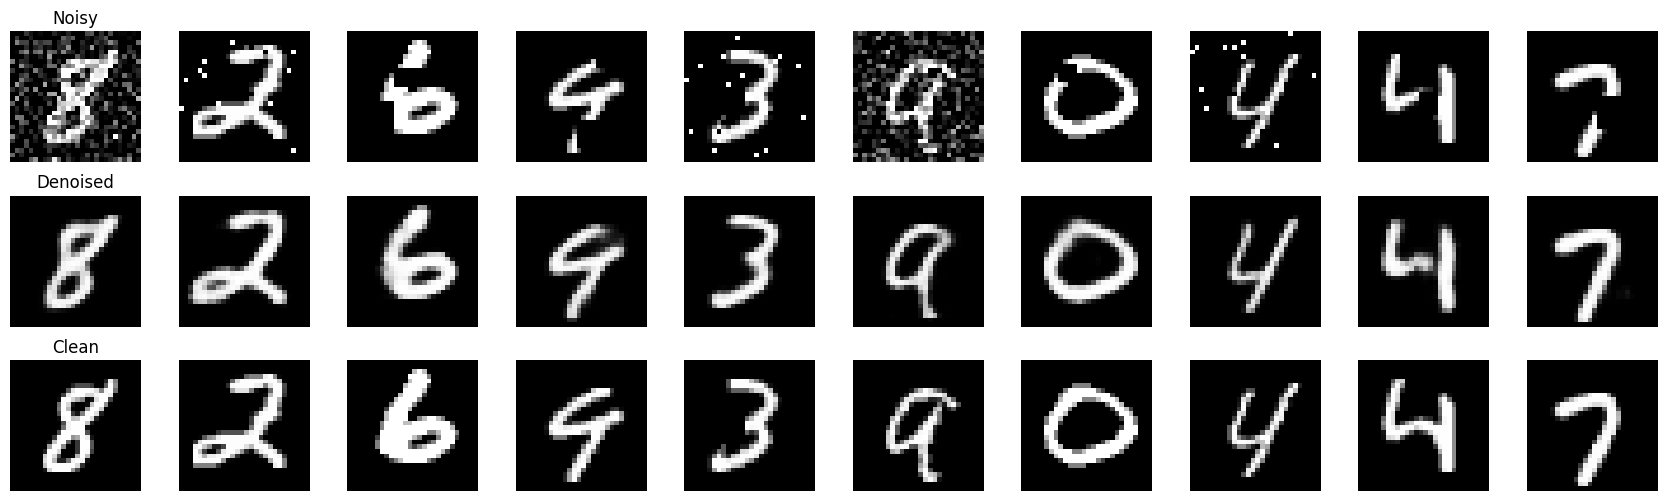

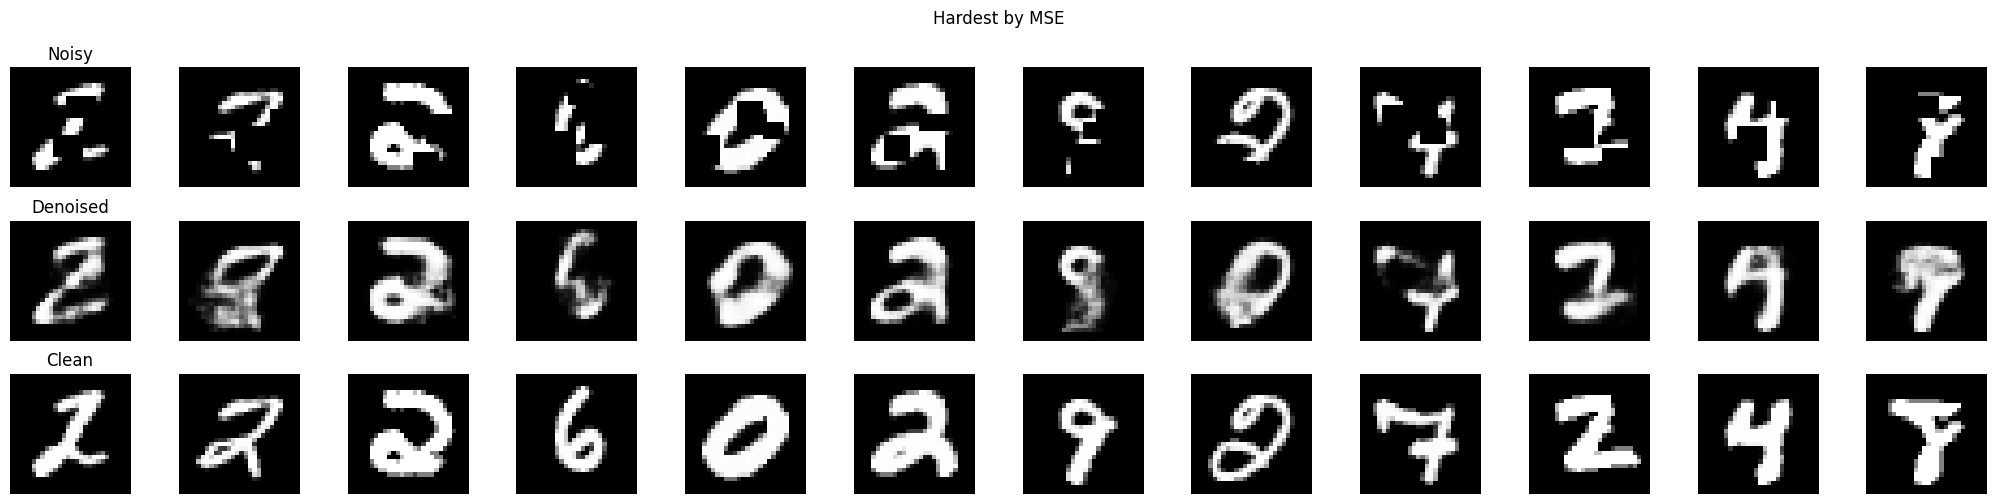

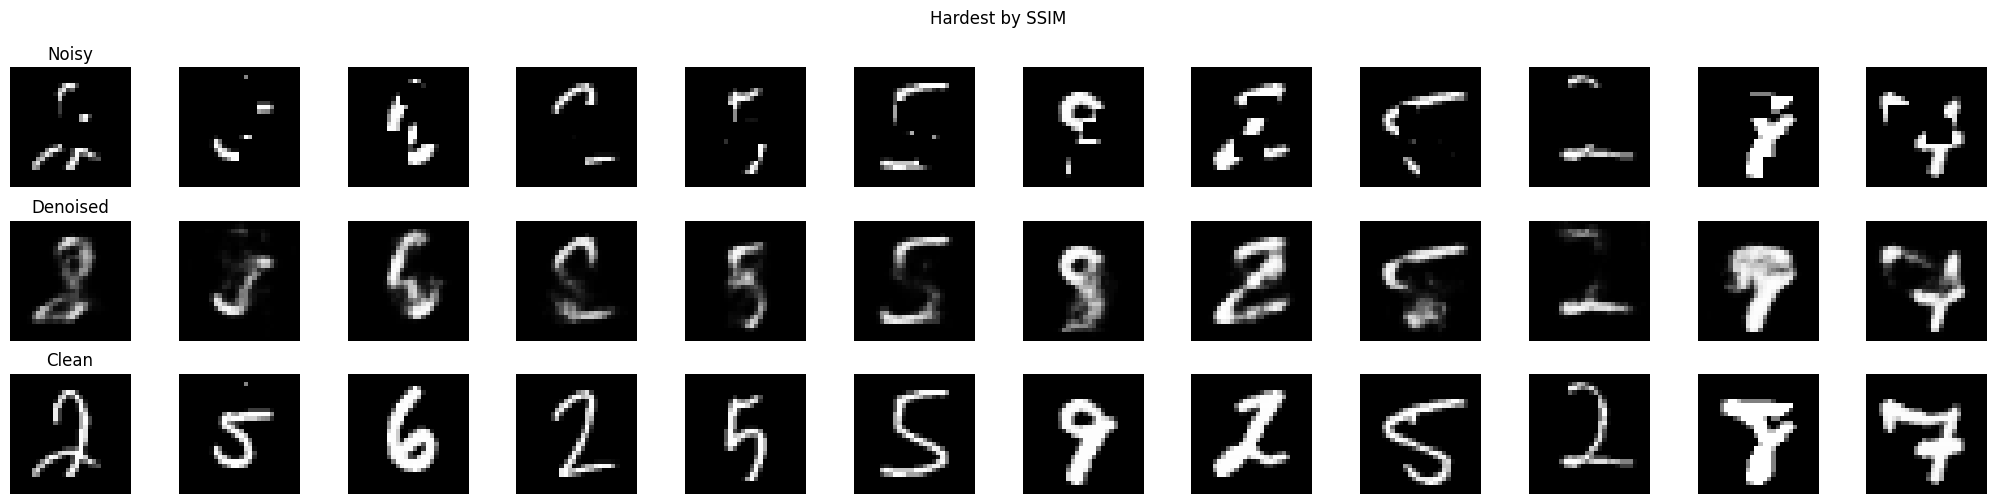

In [12]:
# 1) Random triplets after training
show_triplets(autoencoder, x_test_noisy, x_test, n=10, seed=7, savepath="triplets.png")

# # 2) Preview what your corruption pipeline looks like (uses your corrupt_batch)
# show_corruption_grid(x_test, corrupt_batch, n=12, title="MNIST corruptions (Gaussian / S&P / Cutout)")

# 3) Investigate failure cases
show_hard_cases(autoencoder, x_test_noisy, x_test, k=12, metric="mse", savepath="hard_mse.png")
show_hard_cases(autoencoder, x_test_noisy, x_test, k=12, metric="ssim", savepath="hard_ssim.png")


## Outlier Detection

We will use the same autoencoder design with a latent space of dimension 16, to find handwritten letters mixed in with digits. 

Letters are from the EMNIST dataset, examples:

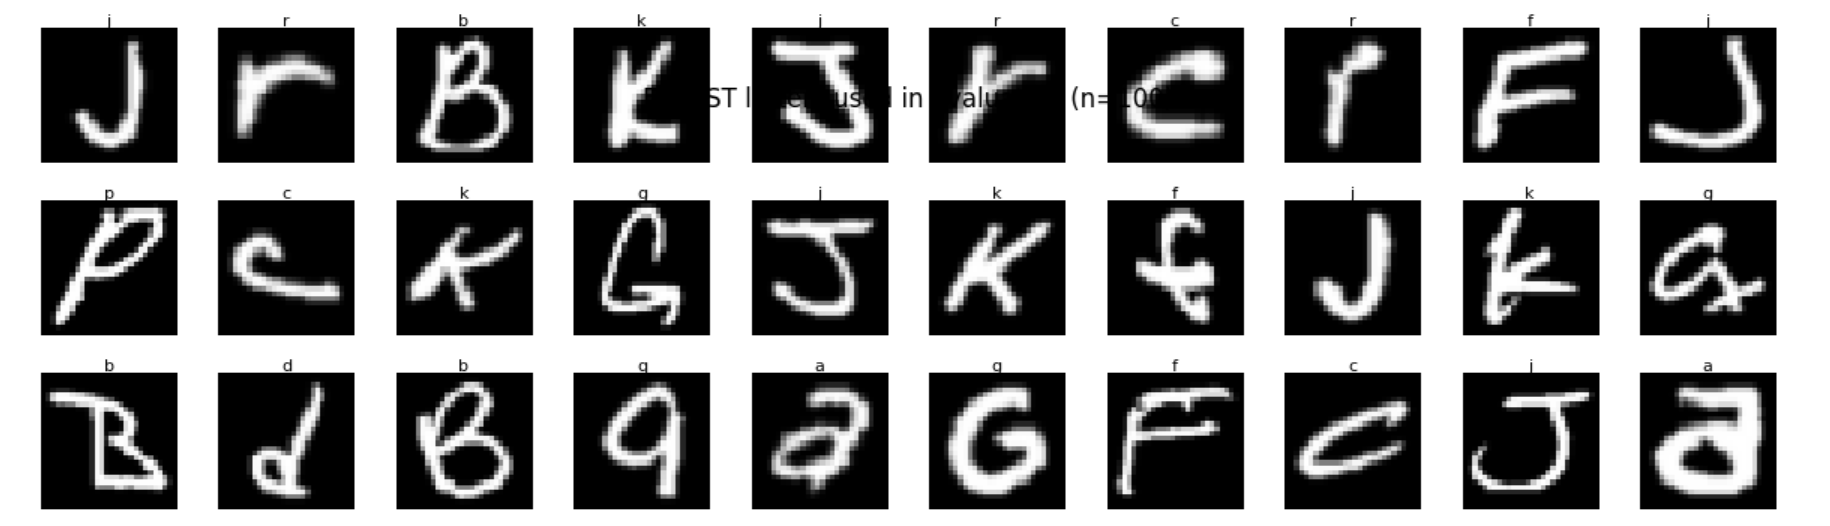

In [13]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("crawford/emnist")

print("Path to dataset files:", path)

Path to dataset files: /Users/waynesnyder/.cache/kagglehub/datasets/crawford/emnist/versions/3


Using: /Users/waynesnyder/.cache/kagglehub/datasets/crawford/emnist/versions/3/emnist-letters-test.csv


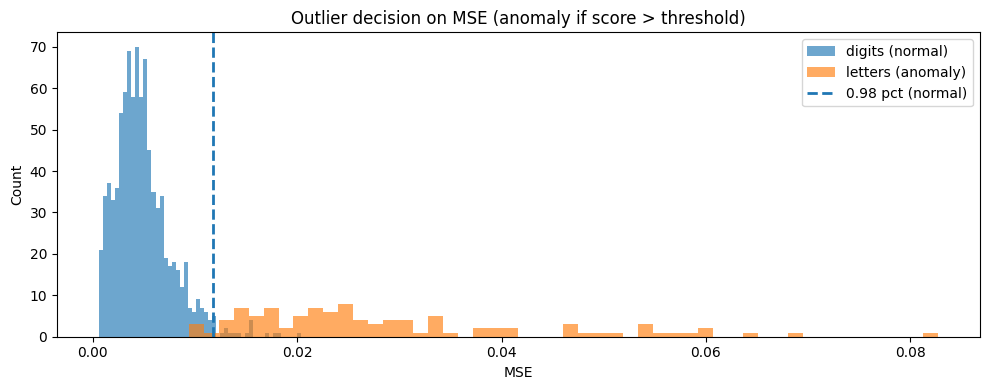

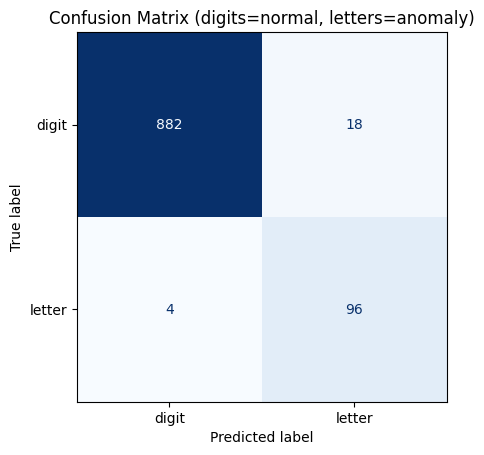

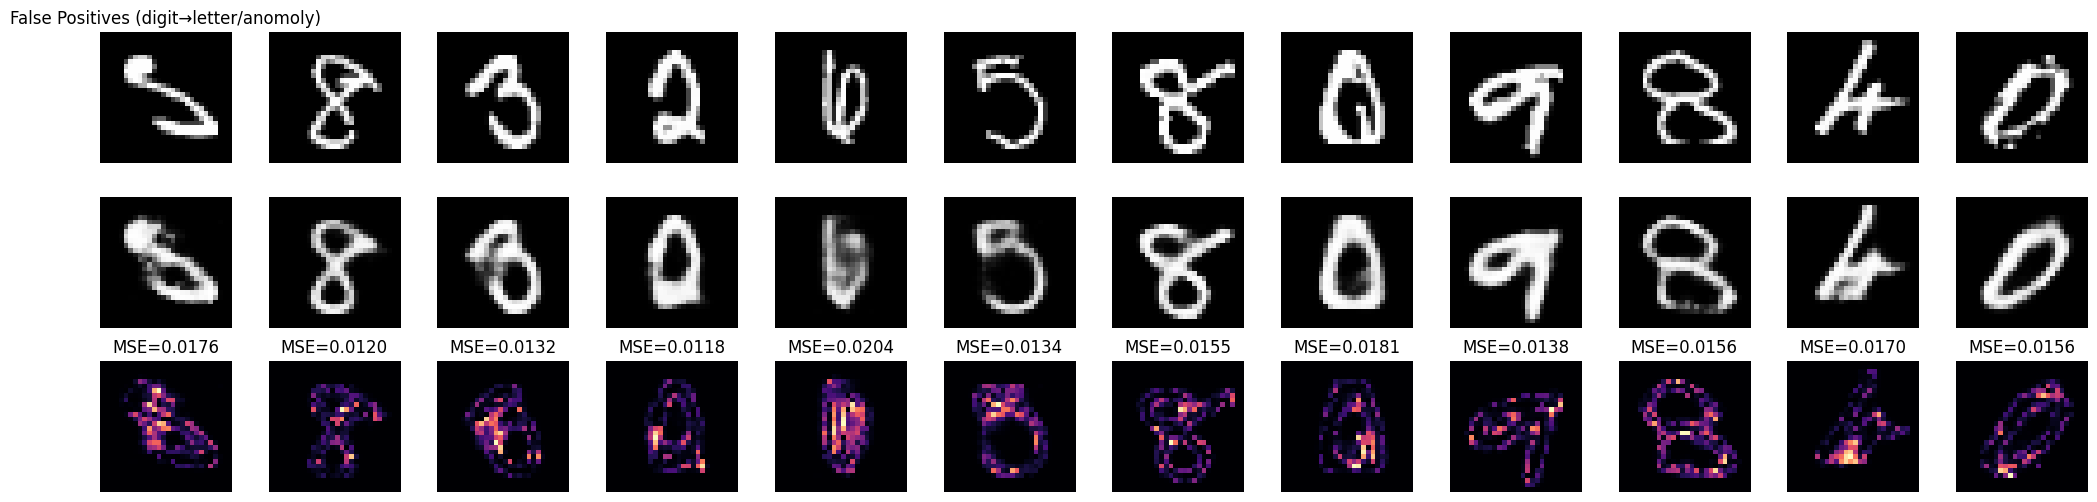

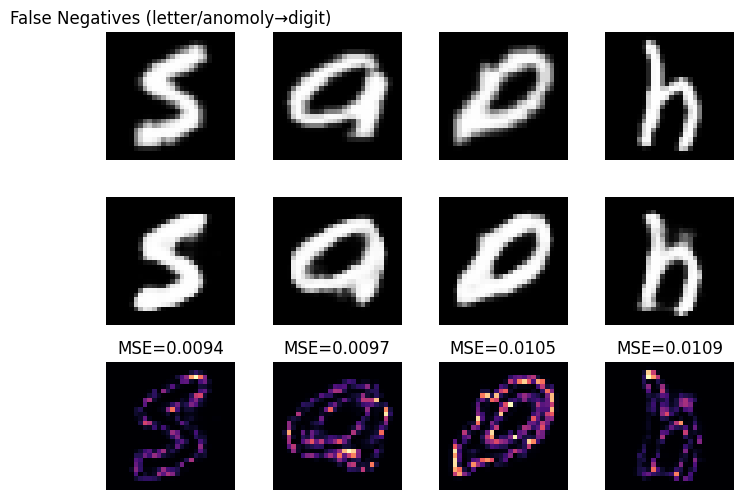

MSE means -> digits: 0.004877 | letters(no 'o'): 0.028786
SSIM means -> digits: 0.9374 | letters(no 'o'): 0.7657


In [28]:
# ==== EMNIST Letters from Kaggle CSV, excluding 'o' ====
import os, glob, numpy as np, pandas as pd, matplotlib.pyplot as plt, tensorflow as tf, kagglehub

# CONFIG

# ----- Build mixed eval set -----
n_digits = 900
n_letters = 100

# Threshold from normals (digits) only
threshold = 0.98

# Locate dataset folder
emnist_dir = kagglehub.dataset_download("crawford/emnist")
letters_csv = glob.glob(os.path.join(emnist_dir, "**", "emnist-letters-test.csv"), recursive=True)[0]
print("Using:", letters_csv)

# Load (label in col0, pixels in cols 1..784)
df = pd.read_csv(letters_csv, header=None)
y_letters = df.iloc[:, 0].to_numpy(np.int32)           # 1..26 → 'a'..'z'
X_letters = df.iloc[:, 1:].to_numpy(np.uint8)

# --- Correct orientation to match MNIST style (upright, not mirrored) ---
# 1. reshape to 28x28
# 2. rotate 90° clockwise
# 3. flip left–right  ✅
X_letters = X_letters.reshape(-1, 28, 28)
X_letters = np.rot90(X_letters, k=-1, axes=(1, 2))
X_letters = np.flip(X_letters, axis=2)  # horizontal flip
x_letters = (X_letters.astype("float32") / 255.0)[..., None]

# (Optional) exclude visually confusing letters
exclude = {15, 12, 9, 26}  # 'o', 'l', 'i', 'z'
mask = ~np.isin(y_letters, list(exclude))
x_letters, y_letters = x_letters[mask], y_letters[mask]

# ==== MNIST digits (normal) ====
(_, _), (x_digits, _) = tf.keras.datasets.mnist.load_data()
x_digits = (x_digits.astype("float32") / 255.0)[..., None]

rng = np.random.default_rng(42)

idx_d = rng.choice(len(x_digits), n_digits, replace=False)
idx_l = rng.choice(len(x_letters), n_letters, replace=False)

x_eval = np.concatenate([x_digits[idx_d], x_letters[idx_l]], axis=0)
y_is_out = np.array([0] * n_digits + [1] * n_letters, dtype=np.int32)

# Shuffle so classes are mixed
perm = rng.permutation(len(x_eval))
x_eval, y_is_out = x_eval[perm], y_is_out[perm]

# ----- Score with your trained autoencoder -----
x_rec = autoencoder.predict(x_eval, batch_size=256, verbose=0)
mse = np.mean((x_eval - x_rec) ** 2, axis=(1, 2, 3))
ssim = tf.image.ssim(x_eval, x_rec, max_val=1.0).numpy()


thr = np.quantile(mse[y_is_out == 0], threshold)
y_hat = (mse > thr).astype(np.int32)

# ---- Confusion matrix + misclassified visualizations ----
def confusion_2x2(y_true, y_pred):
    cm = np.zeros((2, 2), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1
    return cm

cm = confusion_2x2(y_is_out, y_hat)

# --- Histogram with decision line ---
plt.figure(figsize=(10, 4))
bins = 50
plt.hist(mse[y_is_out == 0], bins=bins, alpha=0.65, label="digits (normal)")
plt.hist(mse[y_is_out == 1], bins=bins, alpha=0.65, label="letters (anomaly)")
plt.axvline(thr, linestyle="--", linewidth=2, label=f"{threshold} pct (normal)")
plt.xlabel("MSE"); plt.ylabel("Count")
plt.title("Outlier decision on MSE (anomaly if score > threshold)")
plt.legend(); plt.tight_layout(); plt.show()

# Pretty confusion matrix if sklearn is available
try:
    from sklearn.metrics import ConfusionMatrixDisplay
    disp = ConfusionMatrixDisplay(cm, display_labels=["digit", "letter"])
    disp.plot(values_format="d", cmap="Blues", colorbar=False)
    plt.title("Confusion Matrix (digits=normal, letters=anomaly)")
    plt.show()
except Exception:
    pass

# --- Visualization helper for misclassified examples ---
def show_misclassified(title, idxs, x_in, x_rec, mse, k=12):
    idxs = np.array(idxs)
    if len(idxs) == 0:
        print(f"No {title.lower()}.")
        return
    sel = idxs[:k]
    cols = len(sel)
    plt.figure(figsize=(1.7 * cols, 5.1))
    for i, j in enumerate(sel):
        ax = plt.subplot(3, cols, i + 1)
        plt.imshow(x_in[j].squeeze(), cmap="gray", vmin=0, vmax=1)
        plt.axis("off")
        if i == 0: ax.set_title(title)
        ax = plt.subplot(3, cols, i + 1 + cols)
        plt.imshow(x_rec[j].squeeze(), cmap="gray", vmin=0, vmax=1)
        plt.axis("off")
        ax = plt.subplot(3, cols, i + 1 + 2 * cols)
        err = np.abs(x_in[j] - x_rec[j]).squeeze()
        plt.imshow(err, cmap="magma")
        plt.axis("off")
        ax.set_title(f"MSE={mse[j]:.4f}")
    plt.tight_layout(); plt.show()

fp_idx = np.where((y_is_out == 0) & (y_hat == 1))[0]
fn_idx = np.where((y_is_out == 1) & (y_hat == 0))[0]
show_misclassified("False Positives (digit→letter/anomoly)", fp_idx, x_eval, x_rec, mse)
show_misclassified("False Negatives (letter/anomoly→digit)", fn_idx, x_eval, x_rec, mse)

# --- Quick summary ---
print(f"MSE means -> digits: {mse[y_is_out==0].mean():.6f} | letters(no 'o'): {mse[y_is_out==1].mean():.6f}")
print(f"SSIM means -> digits: {ssim[y_is_out==0].mean():.4f} | letters(no 'o'): {ssim[y_is_out==1].mean():.4f}")


In [15]:
# This cell shows all 100 of the letters inserted as outliers into the dataset

# import numpy as np, matplotlib.pyplot as plt

# # Helper: 1..26 -> 'a'..'z'
# to_char = lambda k: chr(ord('a') + int(k) - 1)

# # Pull the chosen letters and labels
# letters_100 = x_letters[idx_l]                 # (100, 28, 28, 1) in [0,1]
# labels_100  = y_letters[idx_l]                 # (100,) with values 1..26
# chars_100   = [to_char(k) for k in labels_100]

# # Plot 10x10 grid
# rows, cols = 10, 10
# plt.figure(figsize=(12, 12))
# for i in range(len(idx_l)):
#     ax = plt.subplot(rows, cols, i + 1)
#     ax.imshow(letters_100[i].squeeze(), cmap="gray", vmin=0, vmax=1)
#     ax.axis("off")
#     ax.set_title(chars_100[i], fontsize=8, pad=1)
# plt.suptitle("EMNIST letters used in evaluation (n=100)", y=0.92)
# plt.tight_layout()
# plt.show()




# Appendix: Visualizing Latent Spaces in 1, 2, and 3 Dimensions



* With **latent_dim = 1**, the encoder maps each image to a **single scalar** (z \in \mathbb{R}). Yes, each digit image becomes a float.
* The decoder then learns a function (g:\mathbb{R}\to \text{image}) that turns that scalar back into a 28×28 image.
* The network tries to arrange digits **along a 1-D curve** (a “nonlinear PCA line”) so nearby (z) values reconstruct similar-looking digits.

  * Easy, “round” digits (like **0**) often get their own smooth region.
  * Ambiguous shapes (**4/9/7** etc.) **collide** on the same 1-D axis, so reconstructions look like “averaged” or “9-ish” digits.

### Visuals you can make now (1-D latent)

**A) See where each test image lands on the line**

In [16]:
# import numpy as np
# import matplotlib as mpl
# import matplotlib.pyplot as plt
# from matplotlib.colors import ListedColormap

# # 1) Build a custom 10-color palette from tab10, but make "7" more distinct
# base = list(mpl.colormaps['tab10'].colors)  # 10 RGB tuples
# colors = base.copy()
# colors[7] = (0.80, 0.20, 0.80)  # vivid magenta for digit 7 (high contrast)
# cmap_digits = ListedColormap(colors, name='digits10_custom')

# # Get 1-D latents
# z_test = encoder.predict(X_test, verbose=0).squeeze()

# # 2) Scatter along the 1-D axis with custom colors
# plt.figure(figsize=(10, 3))
# jitter = (np.random.rand(len(z_test)) - 0.5) * 0.1
# point_colors = np.array([colors[d] for d in y_test])  # color per sample
# plt.scatter(z_test, jitter, c=point_colors, s=6)
# plt.yticks([])
# plt.xlabel("latent scalar z")
# plt.title("1-D latent positions")
# plt.show()

# # 3) Per-class histograms using the same palette
# plt.figure(figsize=(10, 6))
# bins = 60
# for d in range(10):
#     sel = (y_test == d)
#     hist, edges = np.histogram(z_test[sel], bins=bins)
#     centers = 0.5 * (edges[1:] + edges[:-1])
#     plt.plot(centers, hist, label=str(d), color=colors[d])
# plt.xlabel("z")
# plt.ylabel("count")
# plt.title("Distribution of latent space by class")
# plt.legend(ncol=5, fontsize=8)
# plt.show()


### 1-Dimensional Latent Space

The autocoder learns to associate each image with a scalar value. 

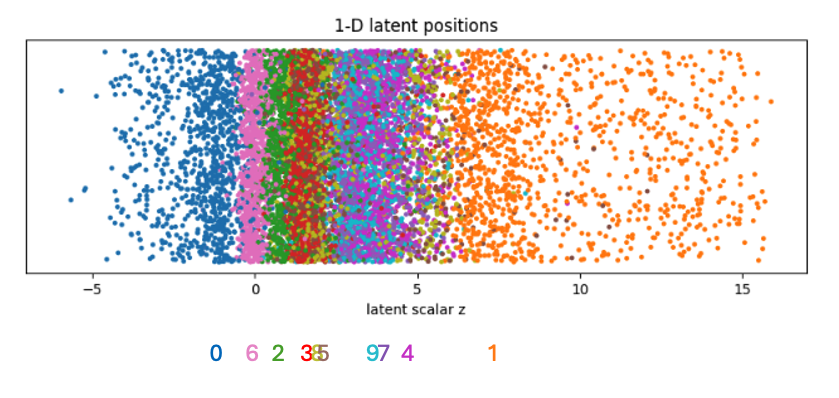

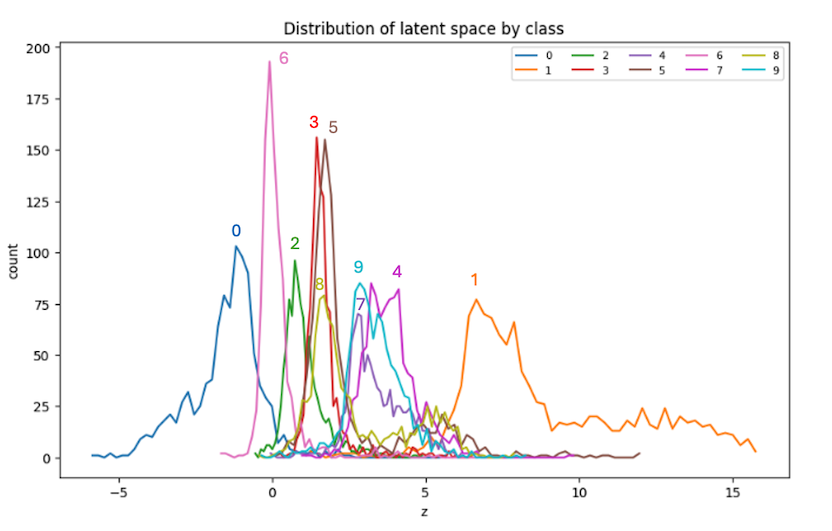

Here's how it did reconstructing digits:

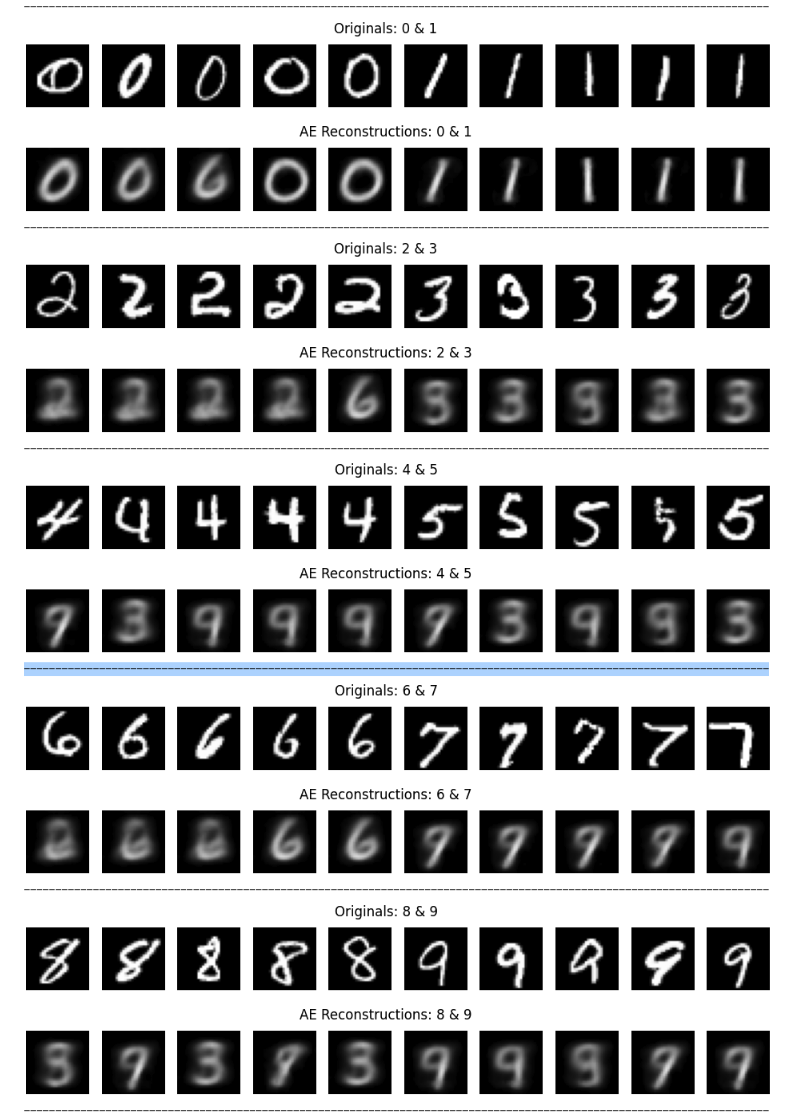

### Moving to 2-D latent space

Two dimensions let the model “spread out” classes on a surface instead of a line, reducing collisions and blur. 


In [17]:
# # Get 2-D latents
# z2_test = encoder.predict(X_test, verbose=0)  # shape (N, 2)

# plt.figure(figsize=(12, 12))
# plt.scatter(z2_test[:, 0], z2_test[:, 1], c=y_test, s=4, cmap="tab10", alpha=0.7)
# plt.xlabel("z1"); plt.ylabel("z2")
# plt.titlbe("2-D latent space colored by digit")
# plt.axis("equal")
# plt.show()

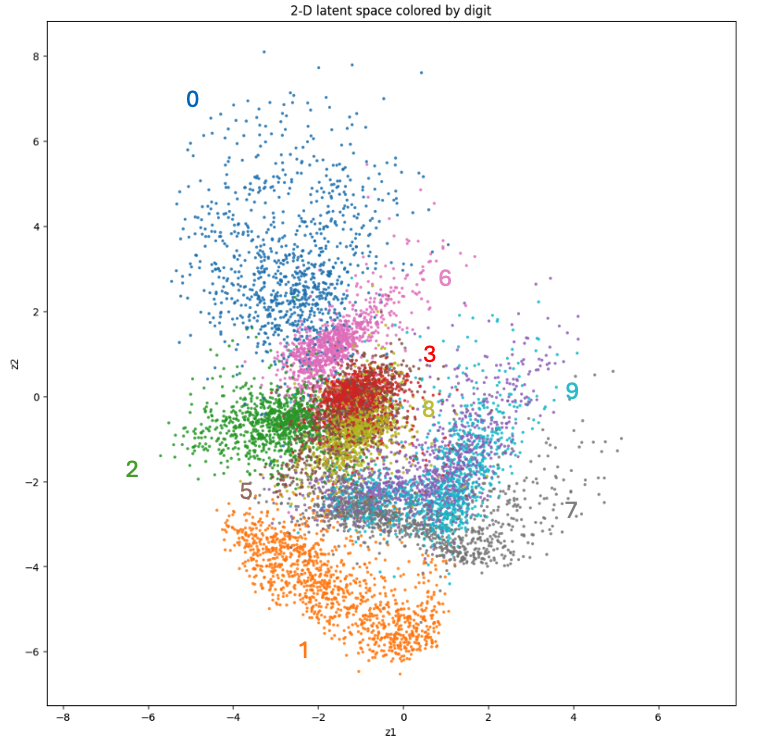

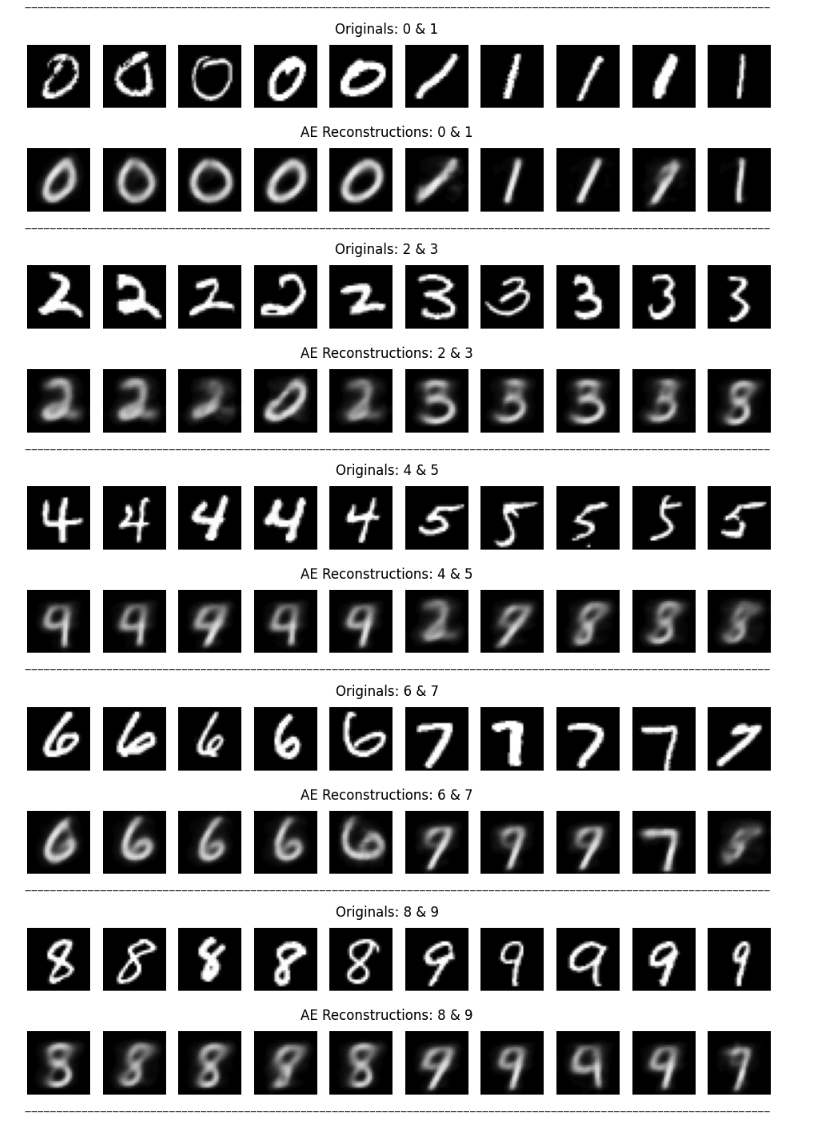

### MNIST digits in 3-Dimensional Latent Space

In [18]:
# import matplotlib.pyplot as plt
# import matplotlib as mpl
# from mpl_toolkits.mplot3d import Axes3D  # noqa

# # data & colors
# z3 = encoder.predict(X_test, verbose=0)
# base = list(mpl.colormaps['tab10'].colors)
# pt_colors = [base[d] for d in y_test]

# views = [
#     ("Iso (elev=25, azim=35)", 25, 35),
#     ("Opposite (elev=25, azim=215)", 25, 215),
#     # uncomment two more if you want 2×2
#     ("Top (elev=85, azim=35)", 85, 35),
#     ("Side (elev=10, azim=120)", 10, 120),
# ]

# fig = plt.figure(figsize=(12, 9))
# for i, (title, elev, azim) in enumerate(views):
#     ax = fig.add_subplot(2, 2, i+1, projection='3d')
#     ax.scatter(z3[:,0], z3[:,1], z3[:,2], c=pt_colors, s=6, alpha=0.7)
#     ax.set_xlabel("z1"); ax.set_ylabel("z2"); ax.set_zlabel("z3")
#     ax.view_init(elev=elev, azim=azim)
#     ax.set_title(title)

# plt.tight_layout()
# plt.show()



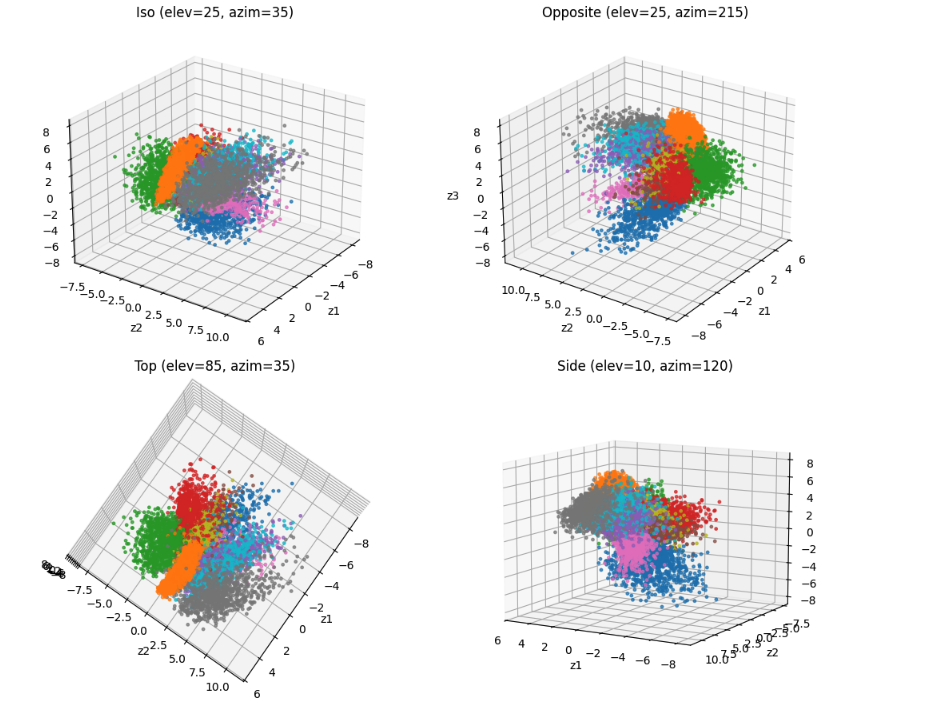